In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Conv1D,Add,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
import pandas as pd
from tqdm import tqdm
import os
import natsort
from glob import glob
import numpy as np
import warnings
import json

warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices, 'GPU')

In [4]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    #! GPU 사용 가능
    for gpu in gpus:
        print("GPU:", gpu)
else:
    #! GPU 사용 불가능
    print("GPU not found")

GPU not found


### Data load 

<Axes: >

100%|██████████| 2193/2193 [00:00<00:00, 2367.74it/s]


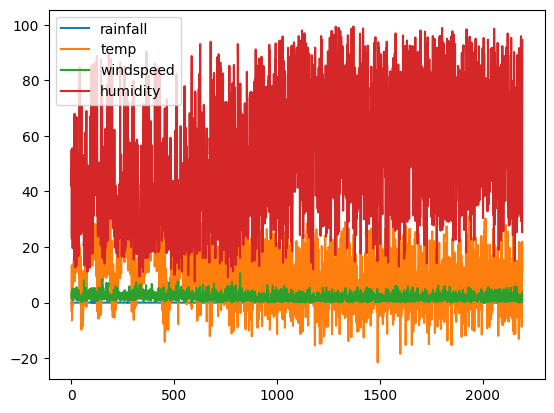

In [5]:
image_size=32

path=f"D:/firedata/npy/train/"

height_train=np.load(path+'Height_train.npy')
ndvi_train=np.load(path+'NDVI_train.npy')
slope_train=np.load(path+'Slope_train.npy')
landuse_train=np.load(path+'Landuse_train.npy')
popden_train=np.load(path+'population_density_train.npy')

tabular_data=pd.read_csv("D:/firedata/climate_train.csv")
tabular_data.drop(['lon', 'lat'],axis=1,inplace=True)
tabular_data=tabular_data.replace(32767.0,-9999)
#tabular_data=tabular_data.replace(-9999.0,0)
tabular_data[['rainfall','temp','windspeed','humidity']].plot()
x,y=[],[]
for j in tqdm(range(len(tabular_data))):
    x.append(np.array(tabular_data.loc[j, ['humidity', 'rainfall', 'temp', 'windspeed']]).astype(float))
    y.append(np.array(tabular_data.loc[j, ['target']]).astype(float))
climate = np.array(x)
y = np.array(y)

In [23]:
height_input = Input(shape=(image_size, image_size, 3), name='height_input')
ndvi_input = Input(shape=(image_size, image_size, 3), name='ndvi_input')
slope_input = Input(shape=(image_size, image_size, 3), name='slope_input')
landuse_input = Input(shape=(image_size, image_size, 3), name='landuse_input')
popden_input = Input(shape=(image_size, image_size, 3), name='popden_input')
climate_input = Input(shape=(4,1), name='climate_input')

def residual_block(input_layer, filters, kernel_size):
    x = Conv2D(filters, kernel_size, padding='same')(input_layer)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    
    if input_layer.shape[-1] != filters:
        input_layer = Conv2D(filters, (1, 1), padding='same')(input_layer)
    
    x = Add()([input_layer, x])
    x = Activation('relu')(x)
    return x

def res_layers(input_layer):
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(input_layer)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
    
    x = residual_block(x, 64, (3, 3))
    x = residual_block(x, 64, (3, 3))
    
    x = residual_block(x, 128, (3, 3))
    x = residual_block(x, 128, (3, 3))
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    return x

def cnn_layers(input_layer):
    conv1_im = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
    pool1_im = MaxPooling2D(pool_size=(2,2))(conv1_im)
    
    conv2 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(pool1_im)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    conv4 = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
    
    flatten = Flatten()(pool4)
    
    dense1 = Dense(128, activation='relu')(flatten)
    
    return dense1


def dense_layer(input_layer):
    dense0 = Dense(64, activation='relu')(input_layer)
    dense1 = Dense(64, activation='relu')(dense0)
    flatten = Flatten()(dense1)
    dense2 = Dense(64, activation='relu')(flatten)
    return dense2
    
height_cnn = cnn_layers(height_input)
ndvi_cnn = cnn_layers(ndvi_input)
slope_cnn = cnn_layers(slope_input)
landuse_cnn = cnn_layers(landuse_input)
popden_cnn = cnn_layers(popden_input)
climate_cnn = dense_layer(climate_input)

merged = concatenate([height_cnn, ndvi_cnn, slope_cnn, landuse_cnn, popden_cnn, climate_cnn])

output_layer = Dense(1, activation='sigmoid', name='output_layer')(merged)

model = Model(inputs=[height_input, ndvi_input,slope_input,landuse_input,popden_input,climate_input], outputs=output_layer)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 height_input (InputLayer)      [(None, 24, 24, 3)]  0           []                               
                                                                                                  
 ndvi_input (InputLayer)        [(None, 24, 24, 3)]  0           []                               
                                                                                                  
 slope_input (InputLayer)       [(None, 24, 24, 3)]  0           []                               
                                                                                                  
 landuse_input (InputLayer)     [(None, 24, 24, 3)]  0           []                               
                                                                                           

In [9]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 입력층 정의
height_input = Input(shape=(32, 32, 3), name='height_input')
ndvi_input = Input(shape=(32, 32, 3), name='ndvi_input')
slope_input = Input(shape=(32, 32, 3), name='slope_input')
landuse_input = Input(shape=(32, 32, 3), name='landuse_input')
popden_input = Input(shape=(32, 32, 3), name='popden_input')
climate_input = Input(shape=(4, 1), name='climate_input')

# MobileNet 모델의 인스턴스 생성
mobilenet = MobileNet(include_top=False, weights='imagenet')

def dense_layer(input_layer):
    dense0 = Dense(64, activation='relu')(input_layer)
    dense1 = Dense(64, activation='relu')(dense0)
    flatten = Flatten()(dense1)
    dense2 = Dense(64, activation='relu')(flatten)
    return dense2

# 입력층을 모델에 적용하여 특성 추출
height_features = mobilenet(height_input)
ndvi_features = mobilenet(ndvi_input)
slope_features = mobilenet(slope_input)
landuse_features = mobilenet(landuse_input)
popden_features = mobilenet(popden_input)
climate_features=dense_layer(climate_input)


# 특성 맵을 일렬로 펼침
flatten_height = Flatten()(height_features)
flatten_ndvi = Flatten()(ndvi_features)
flatten_slope = Flatten()(slope_features)
flatten_landuse = Flatten()(landuse_features)
flatten_popden = Flatten()(popden_features)
flatten_climate = Flatten()(climate_features)

# 특성 맵을 병합
merged = concatenate([flatten_height, flatten_ndvi, flatten_slope, flatten_landuse, flatten_popden, flatten_climate])

# 출력층 정의
output_layer = Dense(1, activation='sigmoid', name='output_layer')(merged)

# 모델 정의
model = Model(inputs=[height_input, ndvi_input, slope_input, landuse_input, popden_input, climate_input], outputs=output_layer)

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=['accuracy'])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 climate_input (InputLayer)     [(None, 4, 1)]       0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 4, 64)        128         ['climate_input[0][0]']          
                                                                                                  
 dense_4 (Dense)                (None, 4, 64)        4160        ['dense_3[0][0]']                
                                                                                                  
 height_input (InputLayer)      [(None, 32, 32, 3)]  0           []                               
                                                                                            

In [10]:
x_train = {
    'height_input': height_train,
    'ndvi_input': ndvi_train,
    'slope_input': slope_train,
    'landuse_input': landuse_train,
    'popden_input': popden_train,
    'climate_input':climate
}

In [11]:
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.95:
            print("Reached accuracy threshold (0.9). Stopping training.")
            self.model.stop_training = True
model.fit(x_train, y, epochs=100, batch_size=128, callbacks=[AccuracyThresholdCallback()])

Epoch 1/100
18/18 [==============================] - 14s 449ms/step - loss: 0.7880 - accuracy: 0.6493
Epoch 2/100
18/18 [==============================] - 8s 446ms/step - loss: 0.3036 - accuracy: 0.8782
Epoch 3/100
18/18 [==============================] - 8s 444ms/step - loss: 0.1723 - accuracy: 0.9448
Epoch 4/100
18/18 [==============================] - 8s 449ms/step - loss: 0.1137 - accuracy: 0.9640


In [12]:
#model.save(f"C:/Users/user/fire_model/{path}{image_size}/cnn") 
model.save(f"C:/Users/user/fire_model/mobilenet32") 

INFO:tensorflow:Assets written to: C:/Users/user/fire_model/mobilenet32\assets


INFO:tensorflow:Assets written to: C:/Users/user/fire_model/mobilenet32\assets


In [80]:
y_pred = model.predict(x_test)
y_pred

13/13 [==============================] - 0s 24ms/step


array([[0.9511119 ],
       [0.6638504 ],
       [0.9243032 ],
       [0.36866847],
       [0.96533704],
       [0.50629115],
       [0.894358  ],
       [0.7636744 ],
       [0.99814063],
       [0.5209027 ],
       [0.9760125 ],
       [0.9424071 ],
       [0.9863269 ],
       [0.935752  ],
       [0.92519057],
       [0.67485106],
       [0.98790586],
       [0.9989828 ],
       [0.99818   ],
       [0.9968638 ],
       [0.98516494],
       [0.9779872 ],
       [0.9956075 ],
       [0.7364466 ],
       [0.93447095],
       [0.6338504 ],
       [0.97422516],
       [0.9690676 ],
       [0.77703154],
       [0.9968832 ],
       [0.7898568 ],
       [0.91756684],
       [0.99230975],
       [0.7502356 ],
       [0.9647244 ],
       [0.99972296],
       [0.9894323 ],
       [0.9992107 ],
       [0.8908258 ],
       [0.9659373 ],
       [0.7065911 ],
       [0.9215959 ],
       [0.8963555 ],
       [0.8801547 ],
       [0.99681   ],
       [0.99954003],
       [0.8433061 ],
       [0.938

In [81]:
#forest_input = Input(shape=(32, 32, 3), name='forest_input')
height_input = Input(shape=(image_size, image_size, 3), name='height_input')
ndvi_input = Input(shape=(image_size, image_size, 3), name='ndvi_input')
slope_input = Input(shape=(image_size, image_size, 3), name='slope_input')
landuse_input = Input(shape=(image_size, image_size, 3), name='landuse_input')
popden_input = Input(shape=(image_size, image_size, 3), name='popden_input')
forest_input = Input(shape=(image_size, image_size, 3), name='forest_input')
climate_input = Input(shape=(4,1), name='climate_input')

def residual_block(input_layer, filters, kernel_size):
    x = Conv2D(filters, kernel_size, padding='same')(input_layer)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    
    if input_layer.shape[-1] != filters:
        input_layer = Conv2D(filters, (1, 1), padding='same')(input_layer)
    
    x = Add()([input_layer, x])
    x = Activation('relu')(x)
    return x

def res_layers(input_layer):
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(input_layer)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
    
    x = residual_block(x, 64, (3, 3))
    x = residual_block(x, 64, (3, 3))
    
    x = residual_block(x, 128, (3, 3))
    x = residual_block(x, 128, (3, 3))
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    return x

def cnn_layers(input_layer):
    conv1_im = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
    pool1_im = MaxPooling2D(pool_size=(2,2))(conv1_im)
    
    conv2 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(pool1_im)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    flatten = Flatten()(pool3)
    
    dense1 = Dense(128, activation='relu')(flatten)
    
    return dense1


def dense_layer(input_layer):
    dense0 = Dense(64, activation='relu')(input_layer)
    dense1 = Dense(64, activation='relu')(dense0)
    flatten = Flatten()(dense1)
    dense2 = Dense(64, activation='relu')(flatten)
    return dense2
    
#forest_cnn = cnn_layers(forest_input)
height_cnn = cnn_layers(height_input)
ndvi_cnn = cnn_layers(ndvi_input)
slope_cnn = cnn_layers(slope_input)
landuse_cnn = cnn_layers(landuse_input)
popden_cnn = cnn_layers(popden_input)
forest_cnn = cnn_layers(forest_input)
climate_cnn = dense_layer(climate_input)

merged = concatenate([height_cnn, ndvi_cnn, slope_cnn, landuse_cnn, popden_cnn,forest_cnn, climate_cnn])

output_layer = Dense(1, activation='sigmoid', name='output_layer')(merged)

model = Model(inputs=[height_input, ndvi_input,slope_input,landuse_input,popden_input,forest_input,climate_input], outputs=output_layer)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

378